# Multiclass Image Classification

In this notebook I will show -
* how to read image files(located on different folders) from a .csv file
* fix class imbalance
* simple image preprocessing
* how to use a prebuild model for training and testing

Let's get started 🔥🔥

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.applications import MobileNet, MobileNetV2
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Dense, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [5]:
path = '../../Kaggle/Kaggle 1/dataset/'

Always check the available files/folders before starting

In [6]:
os.listdir(path)

['Test Images', 'test.csv', 'Train Images', 'train.csv']

In [7]:
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

train_df.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


Let's look at some images on the train set

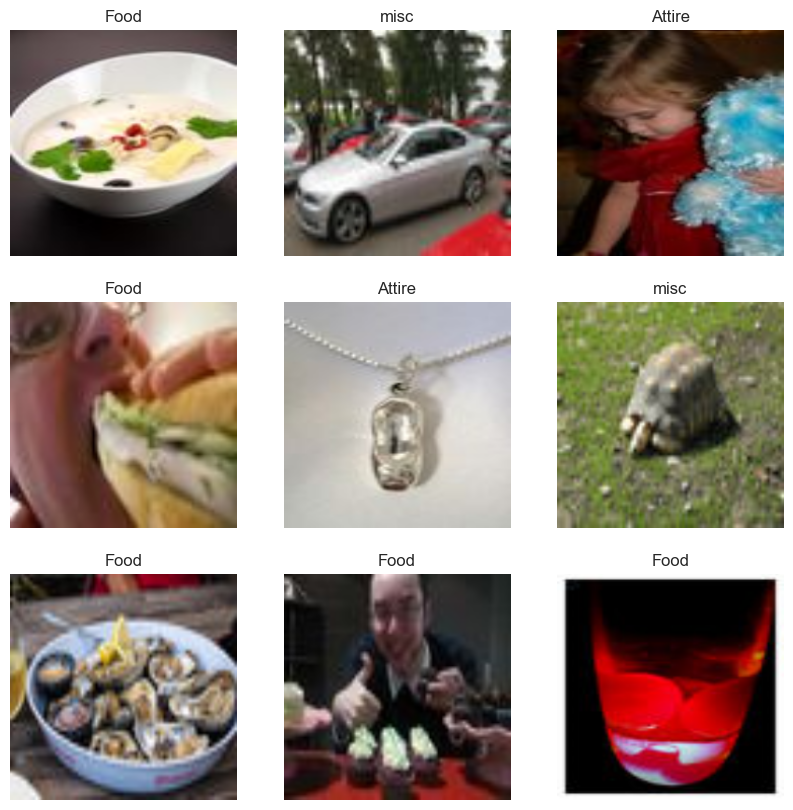

In [8]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = mpimg.imread(path + '/Train Images/' + train_df["Image"][i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(train_df["Class"][i])
    plt.axis("off")

Check how many different classes of image are there

In [9]:
train_df['Class'].unique()

array(['Food', 'misc', 'Attire', 'Decorationandsignage'], dtype=object)

Create a dictionary to convert the unique class names into numerical values

In [10]:
class_map = {
    'Food': 0,
    'Attire': 1,
    'Decorationandsignage': 2,
    'misc': 3
}

inverse_class_map = {
    0: 'Food',
    1: 'Attire',
    2: 'Decorationandsignage',
    3: 'misc'
}

# Check for class imbalance

In [11]:
'''sns.countplot(train_df['Class'])'''

"sns.countplot(train_df['Class'])"

So class 0 has more data than other other classes, we have to fix this

In [12]:
train_df["Class"].value_counts()

Food                    2278
Attire                  1691
misc                    1271
Decorationandsignage     743
Name: Class, dtype: int64

Clearly there is a class imbalance

So, we have to add some similar 'class' data to the other classes in a manner that the class imbalance of other classes will be fixed and also food will remain the most dominant class

In [13]:
balance_attire = (2278 - 1691)
balance_decoration = (2278 - 743) 
balance_misc = (2278 - 1271) 
balance_food = 1000

Now we have to add these number of images to the train_df for each class to remove the class imbalance

In [14]:
recover_balance = { 'Image': [], 'Class': [] }

while balance_food != 0:
    for i in range(train_df.shape[0]):
        if balance_food == 0:
                break
        if train_df.iloc[i]["Class"] == 'Food':
            recover_balance["Image"].append(train_df.iloc[i]["Image"])
            recover_balance["Class"].append(train_df.iloc[i]["Class"])
            balance_food -= 1
            
while balance_attire != 0:
    for i in range(train_df.shape[0]):
        if balance_attire == 0:
                break
        if train_df.iloc[i]["Class"] == 'Attire':
            recover_balance["Image"].append(train_df.iloc[i]["Image"])
            recover_balance["Class"].append(train_df.iloc[i]["Class"])
            balance_attire -= 1
            
while balance_decoration != 0:
    for i in range(train_df.shape[0]):
        if balance_decoration == 0:
                break
        if train_df.iloc[i]["Class"] == 'Decorationandsignage':
            recover_balance["Image"].append(train_df.iloc[i]["Image"])
            recover_balance["Class"].append(train_df.iloc[i]["Class"])
            balance_decoration -= 1
            
while balance_misc != 0:
    for i in range(train_df.shape[0]):
        if balance_misc == 0:
                break
        if train_df.iloc[i]["Class"] == 'misc':
            recover_balance["Image"].append(train_df.iloc[i]["Image"])
            recover_balance["Class"].append(train_df.iloc[i]["Class"])
            balance_misc -= 1

So our new dataframe is created which will balance the data.

In [15]:
balance_df = pd.DataFrame(recover_balance)
balance_df = balance_df.sample(frac = 1)
balance_df.head()

,Image,Class
310,image10684.jpg,Food
3215,image2097.jpg,misc
1849,image10003.jpg,Decorationandsignage
1292,image1916.jpg,Attire
277,image622.jpg,Food


Check if we solve the imbalance

In [16]:
'''temp_df = pd.concat([balance_df, train_df])

sns.countplot(temp_df['Class'])'''

"temp_df = pd.concat([balance_df, train_df])\n\nsns.countplot(temp_df['Class'])"

Yes the class imbalance is now fixed.

# Converting to numerical classes

In [17]:
train_df['Class'] = train_df['Class'].map(class_map).astype(np.uint8)
train_df.head()

,Image,Class
0,image7042.jpg,0
1,image3327.jpg,3
2,image10335.jpg,1
3,image8019.jpg,0
4,image2128.jpg,1


In [18]:
balance_df['Class'] = balance_df['Class'].map(class_map).astype(np.uint8)
balance_df.head()

,Image,Class
310,image10684.jpg,0
3215,image2097.jpg,3
1849,image10003.jpg,2
1292,image1916.jpg,1
277,image622.jpg,0


In [19]:
h, w = 224, 224
batch_size = 64
epochs = 100

Creating train and test set

In [20]:
train_path = path + '/Train Images/'
test_path = path + '/Test Images/'

In [21]:
train_images, train_labels = [], []

for i in range(train_df.shape[0]):
    train_image = cv2.imread(train_path + str(train_df.Image[i]))
    train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
    train_image = cv2.resize(train_image, (h, w))
    train_images.append(train_image)
    train_labels.append(train_df.Class[i])

# After adding the train_df data add balance_df inorder to balance the total training data
for i in range(balance_df.shape[0]):
    train_image = cv2.imread(train_path + str(balance_df.Image[i]))
    train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
    train_image = cv2.resize(train_image, (h, w))
    train_images.append(train_image)
    train_labels.append(balance_df.Class[i])

test_images = []

for i in range(test_df.shape[0]):
    test_image = cv2.imread(test_path + str(test_df.Image[i]))
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = cv2.resize(test_image, (h, w))
    test_images.append(test_image)

train_images = np.array(train_images)
test_images = np.array(test_images)

Now since the **test_images** will be used for prediction we cannot use it as validation set during training of our model.

So we will create a train and test set by splitting the **train_images**

# Creating train and test sets for training our model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_images, to_categorical(train_labels), test_size=0.3, random_state=42)

We will be using a prebuild model MobileNet to train our data

Below is a structure of a mobilenet

know more --> https://towardsdatascience.com/review-mobilenetv1-depthwise-separable-convolution-light-weight-model-a382df364b69

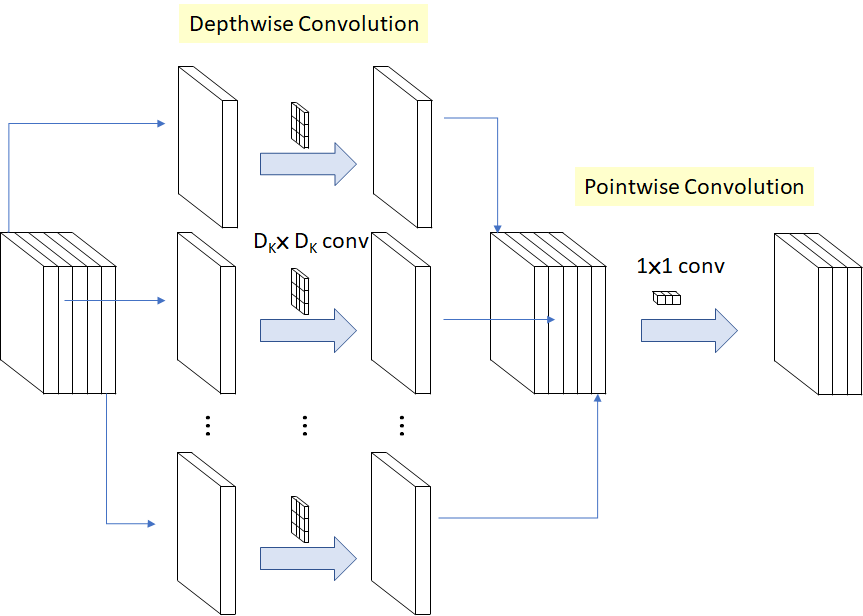

In [23]:
base_model = MobileNet(
    input_shape=(h, w, 3), 
    weights='imagenet',
    include_top=False, 
    pooling='avg'
)

base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

Now we have created our base model

The final dense layer of our CNN will have an activation function softmax. Here define the number of output classes, in this case it's 4 

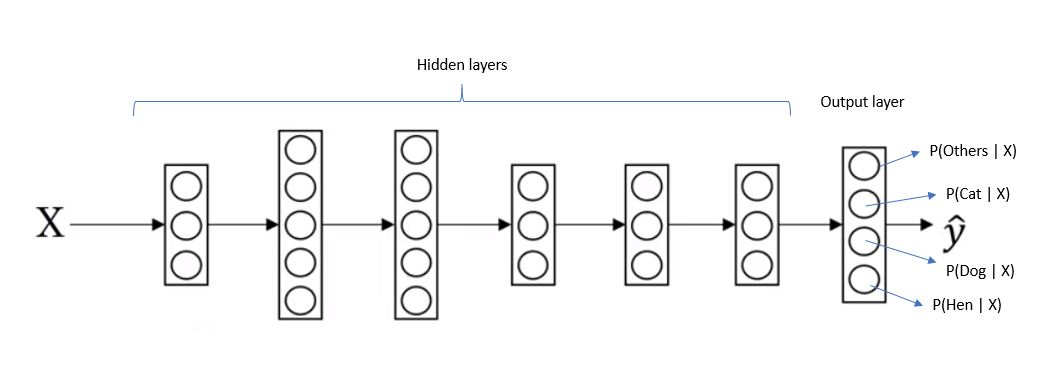

know more about softmax --> https://deepai.org/machine-learning-glossary-and-terms/softmax-layer#:~:text=The%20softmax%20function%20can%20be,be%20difficult%20to%20work%20with.

In [24]:
base_model.trainable = False

output_class = 4

model = Sequential([
  base_model,
  Dense(output_class, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 3,232,964
Trainable params: 4,100
Non-trainable params: 3,228,864
_________________________________________________________________


Now the entire model is created.

We will now define some callbacks. Callbacks basically stops the training process(model is saved) if it detects an increase of loss or overfitting in our model. Callbacks also reduce the learning rate based on model performance.

In [25]:
earlystop = EarlyStopping(monitor='val_loss', patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

Here we will see a simple, easy to use image preprocessing technique

ImageDataGenerator is an image augmentation process where rescaling, zooming, flips and other values are defined. Basically it helps to modify the image so that our model has a less chance of overfitting and underfitting

In [26]:
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Training the model

In [27]:
model.fit(datagen.flow(X_train, y_train, batch_size = batch_size), validation_data = (X_test, y_test), steps_per_epoch = len(X_train) / batch_size, epochs = epochs, callbacks = callbacks)

Epoch 1/100
110/110 [==============================] - 140s 1s/step - loss: 0.9182 - accuracy: 0.6348 - val_loss: 2.3926 - val_accuracy: 0.2502 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 121s 1s/step - loss: 0.6624 - accuracy: 0.7478 - val_loss: 2.3242 - val_accuracy: 0.2627 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 120s 1s/step - loss: 0.5844 - accuracy: 0.7813 - val_loss: 2.4160 - val_accuracy: 0.2848 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 121s 1s/step - loss: 0.5490 - accuracy: 0.7936 - val_loss: 2.1478 - val_accuracy: 0.2762 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 119s 1s/step - loss: 0.5176 - accuracy: 0.8043 - val_loss: 2.1035 - val_accuracy: 0.2844 - lr: 0.0010
Epoch 6/100
110/110 [==============================] - 117s 1s/step - loss: 0.5000 - accuracy: 0.8087 - val_loss: 2.2855 - val_accuracy: 0.2887 - lr: 0.0010
Epoch 7/100
110/110 [==============================] - 120

# Predicting with our model

In [28]:
labels = model.predict(test_images)
print(labels[:4])

101/101 [==============================] - 32s 306ms/step
[[0.00598819 0.32729983 0.5206817  0.14603029]
 [0.07208694 0.09326192 0.18117532 0.6534758 ]
 [0.02001185 0.17667745 0.5202766  0.2830341 ]
 [0.03415509 0.5221144  0.24457026 0.19916031]]


The output shows the probability value of each class for an image.

We will take the class which has the maximum probability value.

In [29]:
label = [np.argmax(i) for i in labels]
print(label[:4])

[2, 3, 2, 1]


Now converting the numerical class to categorical class

In [30]:
class_label = [inverse_class_map[x] for x in label]
print(class_label[:4])

['Decorationandsignage', 'misc', 'Decorationandsignage', 'Attire']


Now just create the submission DataFrame and it's done

In [31]:
submission = pd.DataFrame({ 'Image': test_df.Image, 'Class': class_label })
submission.head()

,Image,Class
0,image6245.jpg,Decorationandsignage
1,image10409.jpg,misc
2,image8692.jpg,Decorationandsignage
3,image10517.jpg,Attire
4,image2580.jpg,Decorationandsignage


# Let's look at some of the predictions

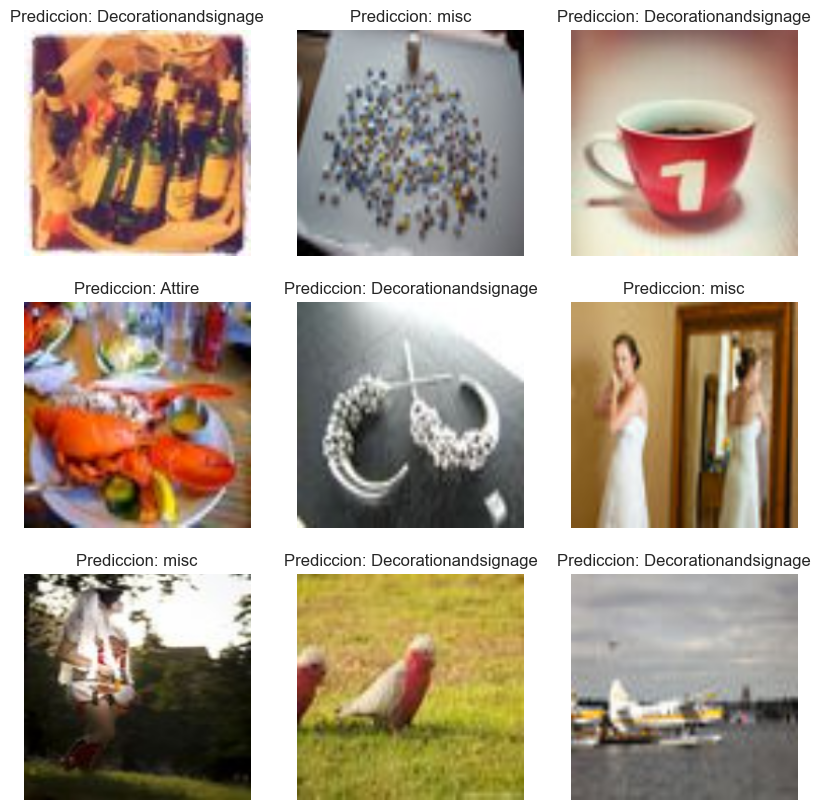

In [33]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = mpimg.imread(path + '/Test Images/' + submission["Image"][i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title("Prediccion: " + submission["Class"][i] + "\n" +
              "Label: ")
    plt.axis("off")

In [30]:
# submission.to_csv('sub.csv', index=False)

Comment your thoughts on this notebook  👇 👇